In [ ]:
# import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import rmsprop

from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys
import re
import glob
import pandas as pd
import shutil
import os

In [2]:
file_path = "./HAM10000_metadata.csv"
data_type = {0:'nv', 1:'mel', 2:'bcc'}
img_dir = './dataset/img'
pre_dir = './ham10000_images'

In [3]:
df = pd.read_csv(file_path)

In [14]:
df_back = df[df['localization'] == 'back']
df_back.to_csv('./skin_cancer_back.csv')

In [3]:
_df_back = pd.read_csv('./skin_cancer_back.csv')

In [4]:
def moveimg(data_type:dict, img_dir:str, pre_dir:str):
    for num in range(3):
        df_type = df[df['dx'] == data_type[num]]
#         df_type2 = df[df['dx_type'] == 'histo']
        filename_type = df_type['image_id'].values
        for i in range(len(filename_type)):
            image_id_type = filename_type[i]
            shutil.copy2(f'{pre_dir}/{image_id_type}.jpg', f'{img_dir}/{data_type[num]}/{data_type[num]}{i}.jpg')

In [5]:
moveimg(data_type, img_dir, pre_dir)

In [22]:
def moveimg_back(data_type:dict, img_dir:str, pre_dir:str):
    for num in range(3):
        df_type = _df_back[_df_back['dx'] == data_type[num]]
#         df_type2 = df[df['dx_type'] == 'histo']
        filename_type = df_type['image_id'].values
        for i in range(len(filename_type)):
            image_id_type = filename_type[i]
            shutil.copy2(f'{pre_dir}/{image_id_type}.jpg', f'{img_dir}/back/{data_type[num]}/{data_type[num]}{i}.jpg')

In [23]:
moveimg_back(data_type, img_dir, pre_dir)

In [17]:
def resizeimg(img_file:str):
    img = cv2.imread(img_file)
    height = img.shape[0]
    width  = img.shape[1]
    img2 = cv2.resize(img, (int(width/6.0), int(height/6.0)))
    return img2

def save_img(data_type:dict, img_dir:str):
    for num in range(3):
        for i in range(len(df[df['dx'] == data_type[num]])):
            img_file = f'{img_dir}/{data_type[num]}/{data_type[num]}{i}.jpg'
            new_img = resizeimg(img_file)
            cv2.imwrite(f"{img_dir}/resize_img/{data_type[num]}/{data_type[num]}{i}.jpg", new_img)
        
def addarray(arr1:list, arr2:list):
    if arr1.ndim == 3:
        zeroarray = np.zeros((2, arr2.shape[0], arr2.shape[1], 3))
        zeroarray[0] += arr1
        zeroarray[1] += arr2
    else:
        zeroarray= np.zeros((arr1.shape[0]+1, arr2.shape[0], arr2.shape[1], 3))
        for i in range(arr1.shape[0]):
            zeroarray[i] += arr1[i]
        zeroarray[zeroarray.shape[0]-1] += arr2
    return zeroarray

In [18]:
save_img(data_type, img_dir)

In [13]:
# ヒストグラム均一化
def equalizeHistRGB(src):

    RGB = cv2.split(src)
    Blue   = RGB[0]
    Green = RGB[1]
    Red    = RGB[2]
    for i in range(3):
        cv2.equalizeHist(RGB[i])

    img_hist = cv2.merge([RGB[0],RGB[1], RGB[2]])
    return img_hist

# ガウシアンノイズ
def addGaussianNoise(src):
    row,col,ch= src.shape
    mean = 0
    var = 0.1
    sigma = 15
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = src + gauss

    return noisy

# salt&pepperノイズ
def addSaltPepperNoise(src):
    row,col,ch = src.shape
    s_vs_p = 0.5
    amount = 0.004
    out = src.copy()
    # Salt mode
    num_salt = np.ceil(amount * src.size * s_vs_p)
    coords = [np.random.randint(0, i-1 , int(num_salt))
                 for i in src.shape]
    out[coords[:-1]] = (255,255,255)

    # Pepper mode
    num_pepper = np.ceil(amount* src.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i-1 , int(num_pepper))
             for i in src.shape]
    out[coords[:-1]] = (0,0,0)
    return out

def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def get_path(data_type:str, img_dir:str):
    path = f"{img_dir}/resize_img/{data_type}/{data_type}*"
    flist = sorted(glob.glob(path), key=numericalSort)
    return flist

In [14]:
if __name__ == '__main__':
    # ルックアップテーブルの生成
    min_table = 50
    max_table = 205
    diff_table = max_table - min_table
    gamma1 = 0.75
    gamma2 = 1.5

    LUT_HC = np.arange(256, dtype = 'uint8' )
    LUT_LC = np.arange(256, dtype = 'uint8' )
    LUT_G1 = np.arange(256, dtype = 'uint8' )
    LUT_G2 = np.arange(256, dtype = 'uint8' )

    LUTs = []

    # 平滑化用
    average_square = (2, 2)

    # ハイコントラストLUT作成
    for i in range(0, min_table):
        LUT_HC[i] = 0

    for i in range(min_table, max_table):
        LUT_HC[i] = 255 * (i - min_table) / diff_table

    for i in range(max_table, 255):
        LUT_HC[i] = 255

    # その他LUT作成
    for i in range(256):
        LUT_LC[i] = min_table + i * (diff_table) / 255
        LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma1) 
        LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma2)

    LUTs.append(LUT_HC)
    LUTs.append(LUT_LC)
    LUTs.append(LUT_G1)
    LUTs.append(LUT_G2)

In [15]:
def augumentation(data_type:dict, img_dir:str):
    for num in range(3):
        j = 1
        flist = get_path(data_type[num], img_dir)

        for file in flist:
            # 画像の読み込み
            img_src = cv2.imread(file)
            trans_img = []
            trans_img.append(img_src)

            # LUT変換
            for i, LUT in enumerate(LUTs):
                trans_img.append(cv2.LUT(img_src, LUT))

            # 平滑化      
            trans_img.append(cv2.blur(img_src, average_square))      

            # ヒストグラム均一化
            trans_img.append(equalizeHistRGB(img_src))

            # ノイズ付加
            trans_img.append(addGaussianNoise(img_src))
            trans_img.append(addSaltPepperNoise(img_src))

            # 反転
            flip_img = []
            for img in trans_img:
                flip_img.append(cv2.flip(img, 1))
            trans_img.extend(flip_img)

    #         base = f"{member}/{member}"+str(j)+"_"
            base = f'{img_dir}/aug_img/{data_type[num]}/{data_type[num]}{j}_'
            j += 1
            img_src.astype(np.float64)
            for i, img in enumerate(trans_img):
                cv2.imwrite(f'{base}{i}.jpg' ,img) 

In [16]:
augumentation(data_type, img_dir)

In [6]:
def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def get_aug_path(data_type:str, img_dir:str):
    path = f"{img_dir}/back/aug_img/{data_type}/{data_type}*"
    flist = sorted(glob.glob(path), key=numericalSort)
    return flist

def img_array(data_type:str, img_dir:str, data_num:int):
    img_array = np.zeros((data_num, 45, 60, 3))
    img_path = get_aug_path(data_type, img_dir)
    for i in range(data_num):
        img_array[i] += np.array(Image.open(img_path[i]))
    img_train, img_test = train_test_split(img_array, train_size= 0.7)
    return img_train, img_test

def dataset(data1:list, data2:list, data3:list):
#     datasets = {0:6476, 1:2776}
    data = {0:data1, 1:data2, 2:data3}
    x = np.zeros((int(data1.shape[0])*3, 45, 60, 3))
    for i in range(int(data1.shape[0])):
        for num in range(3):
            data_num = data[num][i]
            x[(3*i)+num] += data_num
    return x

In [7]:
nv_train, nv_test = img_array(data_type[0], img_dir, 3348)
mel_train, mel_test = img_array(data_type[1], img_dir, 3348)
bcc_train, bcc_test = img_array(data_type[2], img_dir, 3348)

/home/deepstation/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
_x_train = dataset(nv_train, mel_train, bcc_train)
_x_test = dataset(nv_test, mel_test, bcc_test)
_y_train = np.array([0, 1, 2]*nv_train.shape[0])
_y_test = np.array([0, 1, 2]*nv_test.shape[0])

In [9]:
x_train = _x_train / 255.0
x_test = _x_test / 255.0
y_train = to_categorical(_y_train)
y_test = to_categorical(_y_test)

In [10]:
print(f'''
Dataset shape
x_train: {x_train.shape} |-> y_train: {y_train.shape},
x_test: {x_test.shape} |-> y_test: {y_test.shape}''')


Dataset shape
x_train: (7029, 45, 60, 3) |-> y_train: (7029, 3),
x_test: (3015, 45, 60, 3) |-> y_test: (3015, 3)


In [12]:
batch_size = 64
num_classes = 3
epochs = 50

In [13]:
model = Sequential()
model.add(Conv2D(64, (4,4), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Conv2D(64, (4,4), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

# model.add(Conv2D(128, (4,4), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
# opt = keras.optimizers.rmsprop()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [14]:
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))

model.save('back_nv_cancer_cnn.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7029 samples, validate on 3015 samples
Epoch 1/50
7029/7029 [==============================] - 2s 333us/step - loss: 0.6539 - acc: 0.7001 - val_loss: 0.6661 - val_acc: 0.7333
Epoch 2/50
7029/7029 [==============================] - 1s 179us/step - loss: 0.4783 - acc: 0.8051 - val_loss: 0.3019 - val_acc: 0.8909
Epoch 3/50
7029/7029 [==============================] - 1s 180us/step - loss: 0.4184 - acc: 0.8481 - val_loss: 0.3191 - val_acc: 0.8803
Epoch 4/50
7029/7029 [==============================] - 1s 177us/step - loss: 0.3755 - acc: 0.8660 - val_loss: 0.4680 - val_acc: 0.7957
Epoch 5/50
7029/7029 [==============================] - 1s 186us/step - loss: 0.3473 - acc: 0.8762 - val_loss: 0.2814 - val_acc: 0.8992
Epoch 6/50
7029/7029 [==============================] - 1s 185us/step - loss: 0.3204 - acc: 0.8916 - val_loss: 0.2308 - val_acc: 0.9144
Epoch 7/50
7029/7029 [==============================] - 1s 205us/step - loss: 0.2932 - acc: 0.9006 - val_loss: 0.2640 - val_acc: 0.9134


In [15]:
def plot_history_lost(hist):
    plt.plot(hist.history['loss'], label='loss for training')
    plt.plot(hist.history['val_loss'], label='loss for validation')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()
    
def plot_history_acc(hist):
    plt.plot(hist.history['acc'], label='accuracy for validation')
    plt.plot(hist.history['val_acc'], label='accuracy for validation')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acuuracy')
    plt.ylim([0,1])
    plt.show()

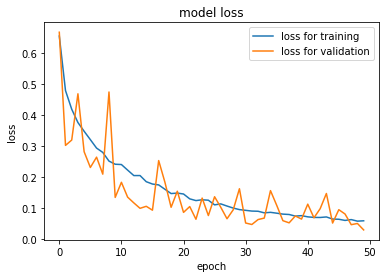

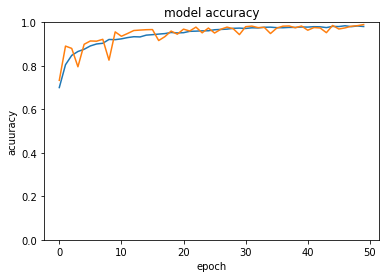

In [16]:
plot_history_lost(history)
plot_history_acc(history)

In [1]:
import keras
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.utils import to_categorical
import glob
import re
import PIL
from PIL import Image
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

Using TensorFlow backend.


In [3]:
model = load_model('back_nv_cancer_cnn.h5')

In [4]:
nv_cancer_labels = np.array([
    'nv',
    'mel',
    'bcc'
])
plt.rcParams['figure.figsize'] = (15.0, 20.0)

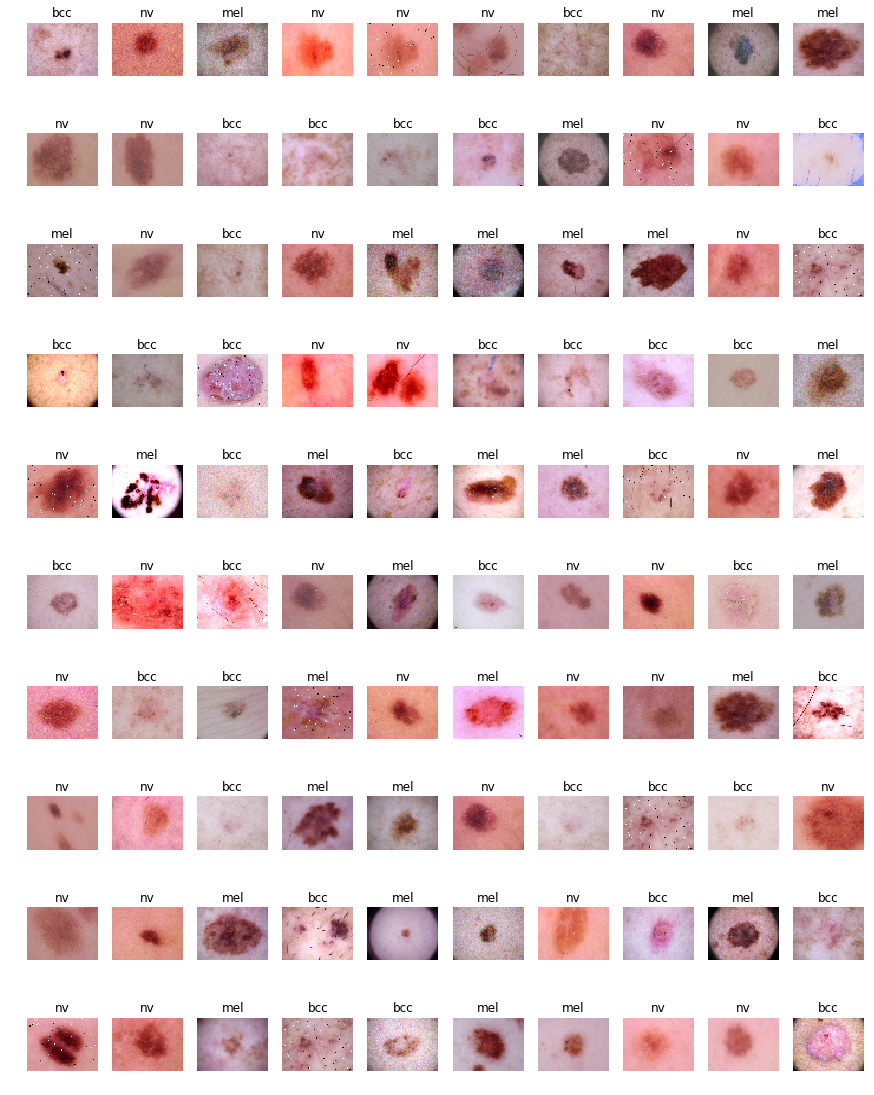

The number of correct answers:  100
The number of mistakes:  0
A correct answer rate:  100.0 %


In [11]:
index = np.zeros(100)
for i in range(100):
    index[i] += random.randint(0,nv_test.shape[0])

right = 0
mistake = 0
for i in range(100):
#     num = i
    num = int(index[i])
#     num = 1851 + i
#     num = 3702 + i
    image = _x_test[num] / 255.0
#   data = convertSize(image)
    data = image.reshape((1, 45, 60, 3))
    plt.subplot(10, 10, i+1)
    plt.imshow(image)
    plt.grid(False)
    plt.axis('off')
    
    pred = model.predict(data, batch_size=64)
#     pred = model.predict(data)
    bestnum  = 0.0
    bestclass = 0
    for n in [0,1,2]:
        if bestnum < pred[0][n]:
            bestnum = pred[0][n]
            bestclass = n
    
    if _y_test[num] == bestclass:
        plt.title(nv_cancer_labels[bestclass])
        right += 1
    else:
        plt.title(nv_cancer_labels[bestclass] + '≠' + nv_cancer_labels[int(_y_test[num])], color = 'red')
        mistake += 1
        
plt.show()
print("The number of correct answers: ", right)
print("The number of mistakes: ", mistake)
print ("A correct answer rate: ", right/(mistake + right) * 100, '%')

In [12]:
_nv_train, _nv_test = img_array(data_type[0], img_dir, 25686)

/home/deepstation/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


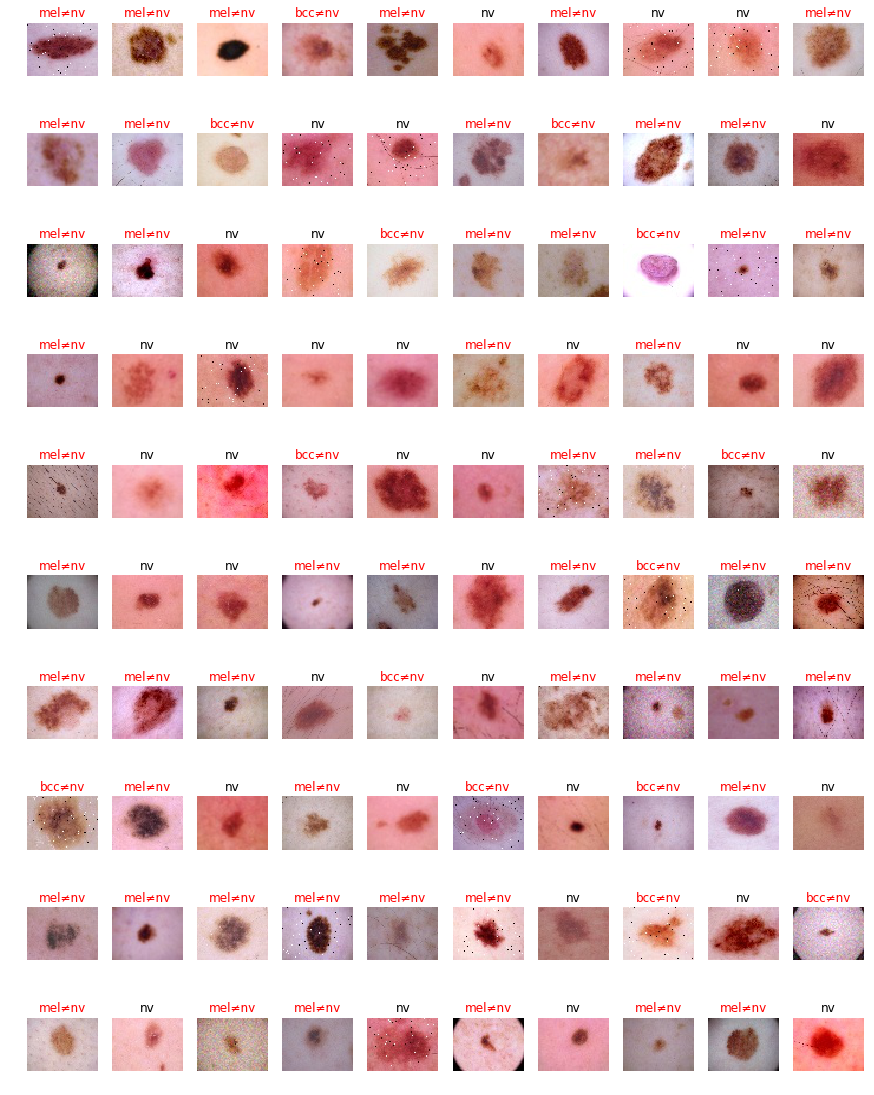

The number of correct answers:  35
The number of mistakes:  65
A correct answer rate:  35.0 %


In [16]:
index = np.zeros(100)
for i in range(100):
    index[i] += random.randint(0,_nv_test.shape[0])

right = 0
mistake = 0
for i in range(100):
#     num = i
    num = int(index[i])
#     num = 1851 + i
#     num = 3702 + i
    image = _nv_test[num] / 255.0
#   data = convertSize(image)
    data = image.reshape((1, 45, 60, 3))
    plt.subplot(10, 10, i+1)
    plt.imshow(image)
    plt.grid(False)
    plt.axis('off')
    
    pred = model.predict(data, batch_size=64)
#     pred = model.predict(data)
    bestnum  = 0.0
    bestclass = 0
    for n in [0,1,2]:
        if bestnum < pred[0][n]:
            bestnum = pred[0][n]
            bestclass = n
    
    if bestclass == 0:
        plt.title(nv_cancer_labels[bestclass])
        right += 1
    else:
        plt.title(nv_cancer_labels[bestclass] + '≠' + nv_cancer_labels[0], color = 'red')
        mistake += 1
        
plt.show()
print("The number of correct answers: ", right)
print("The number of mistakes: ", mistake)
print ("A correct answer rate: ", right/(mistake + right) * 100, '%')